# Основанный на расстоянии подход в задаче линейной классификации

## Постановка задачи

Теперь попробуем разобраться, что делать в случае классификации.

Рассмотрим задачу классификации на два класса. Например, у нас есть данные о лабораторных мышах. Часть из них имеет нормальную массу тела, а часть — мыши с ожирением.

<img src ="https://ml.gan4x4.ru/msu/additions/L02/svm_mouse_example.png" width="800">



Итак:
1. У нас есть набор данных из $N$ объектов (мышей).
2. Для каждого из объектов (мышей) нам известно признаковое описание объекта в виде набора вещественных чисел (вес, длина от носа до кончика хвоста, возраст и т.д.). То есть объекту под номером $i$ соответствует вектор $\vec x_i$.
3. Также для каждого объекта нам известна истинная метка класса. Мы знаем, что объекту с признаковым описанием $\vec x_i$ соответствует метка класса $y_i$. Будем считать, что метки классов принимают значения:
$$y_i =
\begin{cases}
    +1, & \text{для пухляшей}, \\
    -1, & \text{для всех остальных}.
\end{cases}$$

##1D классификация

Рассмотрим **одномерный пример**. У нас есть данные только по **массе мышей**. Часть из них определена как мыши с нормальной массой тела, а часть — как мыши с ожирением.

Чтобы их отделить друг от друга, нам достаточно одного критерия. Мы можем посмотреть на график и визуально определить предельную массу, после которой мыши считаются мышами с ожирением.

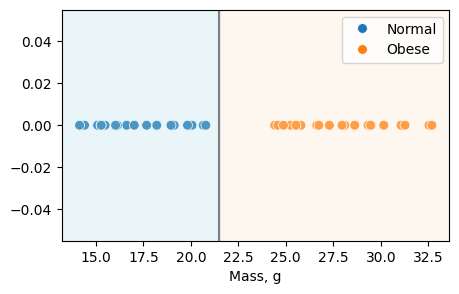

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


custom_cmap = ListedColormap(["#B8E1EC", "#bea6ff", "#FEE7D0"])


def generate_data(total_len=40):
    x = np.hstack(
        [
            np.random.uniform(14, 21, total_len // 2),
            np.random.uniform(24, 33, total_len // 2),
        ]
    )
    y = np.hstack([np.zeros(total_len // 2), np.ones(total_len // 2)])
    return x, y


def plot_data_1d(
    x,
    y,
    total_len=40,
    s=50,
    threshold=None,
    margin=None,
    legend=["Normal", "Obese"],
    marker="o",
):
    ax = sns.scatterplot(x=x, y=np.zeros(len(x)), hue=y, s=s, marker=marker)
    if threshold:
        x_lim, y_lim = ax.get_xlim(), ax.get_ylim()
        XX, YY = np.meshgrid(
            np.linspace(x_lim[0], x_lim[1], 100), np.linspace(y_lim[0], y_lim[1], 100)
        )
        pred = np.sign(XX - threshold)
        plt.contourf(XX, YY, pred, alpha=0.3, cmap=custom_cmap)
        ax.axvline(threshold, color="grey")
    if margin:
        for line in margin:
            ax.axvline(line, color="grey", ls="dashed")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, legend)
    ax.set(xlabel="Mass, g")
    return ax


total_len = 40
np.random.seed(42)
x, y = generate_data(total_len=total_len)
plt.figure(figsize=(5, 3))
ax = plot_data_1d(x, y, threshold=21.5, total_len=total_len)

Теперь, пользуясь нашим простым критерием, попробуем классифицировать каких-то новых (тестовых) мышей $\color{orange}{✭}$ $\color{blue}{✭}$:

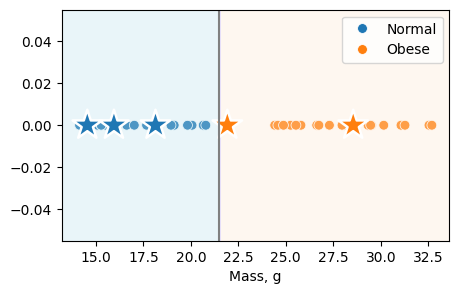

In [ ]:
x_test = np.random.uniform(14, 30, 5)


def classify(x, threshold=21.5):
    y = np.zeros_like(x)
    y[x > threshold] = 1
    return y


total_len = 40
threshold = 21.5

plt.figure(figsize=(5, 3))
ax = plot_data_1d(x, y, threshold=threshold, total_len=total_len)
ax = plot_data_1d(
    x_test, classify(x_test, threshold), total_len=total_len, s=500, marker="*"
)

Одна из тестовых мышей была классифицирована как мышь с ожирением ($\color{orange}{✭}$ на границе), хотя она ближе по массе к мышам без ожирения из обучающей выборки $\color{blue}{●}$. Не порядок!

## Maximum Margin Classifier

Вооружившись этим новым знанием, попробуем классифицировать мышек по-умному. Возьмем крайние точки в каждом кластере. И в качестве порогового значения будем использовать среднее между ними.

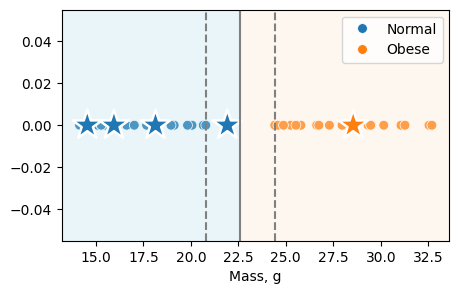

In [ ]:
normal_limit = x[y == 0].max()  # extreme point for 'normal'
obese_limit = x[y == 1].min()  # extreme point for 'obese'

threshold = np.mean([normal_limit, obese_limit])  # separated with mean value

plt.figure(figsize=(5, 3))
ax = plot_data_1d(
    x, y, total_len=total_len, threshold=threshold, margin=[normal_limit, obese_limit]
)
ax = plot_data_1d(
    x_test,
    classify(x_test, threshold=threshold),
    total_len=total_len,
    s=500,
    marker="*",
)

Мы можем посчитать, насколько наша мышь близка к тому, чтобы оказаться в другом классе. Такое расстояние называется **margin**. И оно считается как $\mathrm{margin} = |\mathrm{threshold} - \mathrm{observation}|$.

In [ ]:
margins = np.abs(x_test - threshold)
print(margins)

[6.65109958 0.68088078 8.053495   5.94541509 4.46323163]


Соответственно, если мы посчитаем margins для наших крайних точек `normal_limit` и `obese_limit`, мы найдем самое большое возможное значение margin для нашего классификатора:

In [ ]:
margin_0 = np.abs(normal_limit - threshold)
margin_1 = np.abs(obese_limit - threshold)
print(margin_0, margin_1)

1.8143423746730107 1.8143423746730072


Такой классификатор мы называем **Maximum Margin Classifier**. Он хорошо работает в случае, когда классы не пересекаются.

## 2D классификация

Теперь рассмотрим пример, где мы измерили не только вес мышей, но и их длину от хвоста до носа. Теперь не очевидно, какие точки кластеров у нас являются крайними и как провести разделяющую прямую, чтобы классы были максимально разнесены.

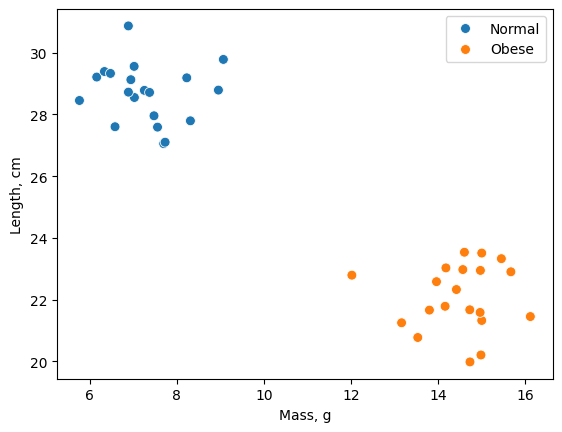

In [ ]:
from sklearn.datasets import make_blobs


def generate_2d_data(total_len=40):
    x, y = make_blobs(n_samples=total_len, centers=2, random_state=42)
    x[:, 0] += 10
    x[:, 1] += 20
    return x, y


total_len = 40
x, y = generate_2d_data(total_len=total_len)

fig = plt.figure()
ax = sns.scatterplot(x=x[:, 0], y=x[:, 1], hue=y, s=50)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ["Normal", "Obese"])
ax.set(xlabel="Mass, g", ylabel="Length, cm")
plt.show()

## SVM: метод множителей Лагранжа

**Идея:** Мы умеем решать задачу классификации в одномерном случае. В многомерном случае попробуем свести задачу к одномерной. Для этого мы будем подбирать вектор весов и смещение чтобы точки преобразовывались, как на картинке:

<img src ="https://ml.gan4x4.ru/msu/additions/L02/svm_hard_margin.png" width="1000">

Подобрать такое преобразование в многомерной задаче — значит провести **разделяющую гиперплоскость** так, чтобы:
1. **Плюсы и минусы** лежали **по разные** стороны от этой плоскости.
2. **Ближайшие** к плоскости **объекты** были от нее как можно **дальше**.



**Гиперплоскость однозначно задается вектором нормали $\vec w$ и смещением $b$.** Мы ищем решение в виде $(\vec w, \vec x) + b$, где $(\vec w, \vec x)$ — это скалярное произведение, $\vec w$ — вектор весов, а $b$ — смещение. Скалярное произведение вектора признаков на вектор нормали будет давать проекцию вектора признаков на вектор нормали (переход к 1d задаче).

Вектора нормали могут быть разной длины. Мы можем нормализовать вектор нормали (сделать длину вектора равной 1). Вместо этого в SVM (support vector machine) принято **фиксировать margin от −1 до 1** (это позволяет удобно записать слагаемое, отвечающее за максимальное удаление объектов от гиперплоскости в качестве слагаемого loss функции).

Вы можете заметить, что **для построения зазора важны не все объекты**, а ограниченное количество объектов, чьи проекции попадают в точки 1 и −1. Такие объекты называются **опорными векторами (support vector)** т.к. в них будет упираться зор между классами.


Итого:
1. Мы хотим подобрать такие $\vec  w$ и $b$, чтобы можно было провести такие гиперплоскости:
$$\large (\vec w, \vec x) + b  = 1$$

- **Лежащие на этой плоскости и выше объекты относятся к классу $+1$:** $\large (\vec w, \vec x_+) + b  \ge 1$

$$\large (\vec w, \vec x) + b  = -1$$

- **Лежащие на этой плоскости и ниже объекты относятся к классу $-1$:** $\large (\vec w, \vec x_-) + b  \le -1$

    Условие того, что  $i$-й объект лежит по правильную сторону от разделяющих поверхностей, можно записать в совместное условие:

    $$\large y_i ((\vec w, \vec x_i) + b )\ge 1,$$

    которое должно выполняться для всех объектов $1 \le i \le N$.

2. Мы хотим разнести эти плоскости как можно дальше. Расстояние между двумя этими **жесткими** границами можно расписать через проекции **опорных** (лежащих на плоскости) **векторов** $\vec x_{sv+}$ (дает проекцию в точку $1$) и $\vec x_{sv1}$ (дает проекцию в точку $-1$):  

$$\text{margin} =\frac{\vec w}{||\vec w||}(\vec x_{sv+} - \vec x_{sv-}) =\frac{(\vec w,\vec x_{sv+})+b-((\vec w,\vec x_{sv-})+b)}{||\vec w||} = \frac{1-(-1)}{||\vec w||} = \frac{2}{||\vec w||}$$

Мы приходим к следующей задаче на экстремум:

$$\max \frac{2}{||\vec w||} \Rightarrow \min \frac{1}{2} ||\vec w||^2$$

при условии:
$$\large y_i ((\vec w, \vec x_i) + b )\ge 1.$$

Задача на условный экстремум для линейно разделимых классов может быть решена аналитически при помощи [метода множителей Лагранжа 📚[wiki]](https://en.wikipedia.org/wiki/Lagrange_multiplier) (позволяет преобразовать задачу условной оптимизации в задачу безусловной оптимизации).

Найти $\alpha_i$, $\vec w$ и $b$, которые реализуют минимум функции потерь:

$$\large L =  \frac{1}{2} ||\vec w||^2 + \sum_i \alpha_i [y_i ((\vec w, \vec x_i) + b) - 1]$$

$\alpha_i\geq0$ — множитель Лагранжа. Он будет не равен нулю только для **опорных векторов**.

Подробный вывод этой формулы:
* [[video] 📺 MIT: Support Vector Machines](https://www.youtube.com/watch?v=_PwhiWxHK8o)

В библиотеке Sklearn минимизация функции $L$ реализована через алгоритм Sequential Minimal Optimization, [предложенный Джоном Платтом в 1998 году 🎓[article]](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr-98-14.pdf). Он работает очень быстро, потому что разбивает задачу на множество подзадач, решаемых аналитически (подробности в статье).

Применим к мышкам метод `svm` из библиотеки Sklearn.

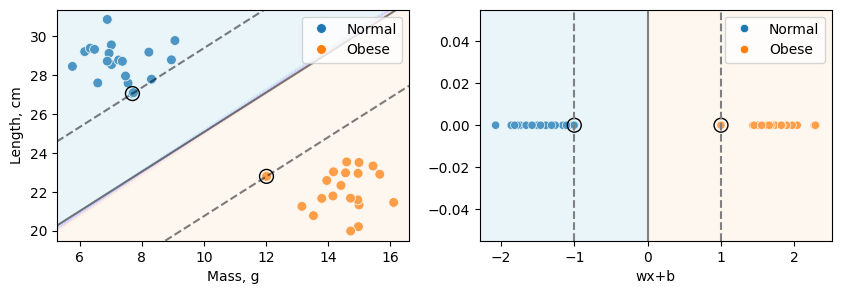

In [ ]:
from sklearn import svm

# Code for illustration, later we will understand how it works
# fit the model, don't regularize for illustration purposes
clf = svm.SVC(kernel="linear", C=1000)
clf.fit(x, y)

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

# first fig
sns.scatterplot(x=x[:, 0], y=x[:, 1], hue=y, s=50, ax=axs[0])
handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend(handles, ["Normal", "Obese"])
axs[0].set(xlabel="Mass, g", ylabel="Length, cm")

# plot the decision function
delta = 0.5
# create grid to evaluate model
YY, XX = np.meshgrid(
    np.linspace(x[:, 1].min() - delta, x[:, 1].max() + delta, 30),
    np.linspace(x[:, 0].min() - delta, x[:, 0].max() + delta, 30),
)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)
pred = np.sign(Z)
axs[0].contourf(XX, YY, pred, alpha=0.3, cmap=custom_cmap)

# plot decision boget_xlimundary and margins
axs[0].contour(
    XX, YY, Z, colors="k", levels=[-1, 0, 1], alpha=0.5, linestyles=["--", "-", "--"]
)
# plot support vectors
axs[0].scatter(
    clf.support_vectors_[:, 0],
    clf.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
)

# second fig
dec_val = clf.decision_function(x)
sns.scatterplot(x=dec_val, y=np.zeros(len(x)), hue=y, ax=axs[1])

x_lim, y_lim = axs[1].get_xlim(), axs[1].get_ylim()
XX, YY = np.meshgrid(
    np.linspace(x_lim[0], x_lim[1], 100), np.linspace(y_lim[0], y_lim[1], 100)
)
pred = np.sign(XX)
axs[1].contourf(XX, YY, pred, alpha=0.3, cmap=custom_cmap)

axs[1].axvline(0, color="grey")
axs[1].axvline(-1, color="grey", ls="dashed")
axs[1].axvline(1, color="grey", ls="dashed")
handles, labels = axs[1].get_legend_handles_labels()
axs[1].legend(handles, ["Normal", "Obese"])
axs[1].set(xlabel="wx+b")

sv = clf.decision_function(clf.support_vectors_)
axs[1].scatter(
    sv, np.zeros_like(sv), s=100, linewidth=1, facecolors="none", edgecolors="k"
)
plt.show()

Альтернативным подходом к решению SVM задачи является Hinge loss, с идеей которого можно ознакомиться по ссылке:
* [[colab] 🥨 Hinge loss и accuracy](https://colab.research.google.com/github/Gan4x4/cv/blob/main/Classic_ML/Hinge_loss_vs_accuracy.ipynb)

## 3D классификация

Если мы добавим еще одно измерение — возраст, мы обнаружим, что наши данные стали трехмерными, а разделяет их теперь не линия, а плоскость.

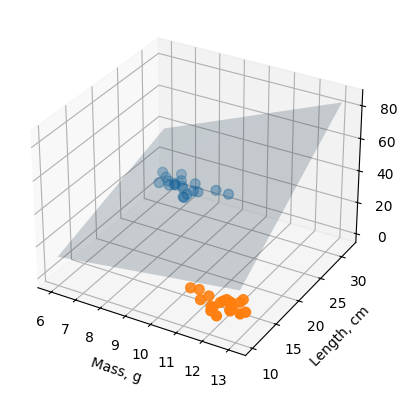

In [ ]:
def generate_3d_data(total_len=40):
    x, y = make_blobs(n_samples=total_len, centers=2, random_state=42, n_features=3)
    x[:, 0] += 10
    x[:, 1] += 20
    x[:, 2] += 10
    return x, y


def plot_data(x, y, total_len=40, s=50, threshold=21.5):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(
        xs=x[:, 0], ys=x[:, 1], zs=x[:, 2], c=y, s=s, cmap="tab10", vmin=0, vmax=9
    )
    # plot the decision function
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    ax.plot_surface(XX, YY, XX * YY * 0.2, alpha=0.2)
    handles, labels = ax.get_legend_handles_labels()
    ax.set(xlabel="Mass, g", ylabel="Length, cm", zlabel="Age, days")
    return ax


total_len = 40
x, y = generate_3d_data(total_len=total_len)
ax = plot_data(x, y, total_len=total_len)

Соответственно, если бы у нас было 4 измерения и больше (например: вес, длина, возраст, кровяное давление), то многомерная плоскость, которая бы разделяла наши классы, называлась бы **гиперплоскость** (рисовать мы ее, конечно же, не будем). Чисто технически, и точка, и линия — тоже гиперплоскости. Но все же гиперплоскостью принято называть то, что нельзя нарисовать на бумаге.

## Многоклассовая классификация

Решение задачи SVM, которое мы рассматривали, касалось задачи бинарной классификации. Однако мы часто будем работать с несколькими классами.

Есть две основные стратегии расширения задачи SVM классификации с двух классов на несколько:
* **One vs rest** (один против всех): каждый класс отделяется от всех других одной прямой (гиперплоскостью).
* **One vs one** (один против одного): классы попарно отделяются друг от друга прямыми (гиперплоскостями).

Создадим датасет из 4 классов для демонстрации отличий между этими способами.

In [ ]:
centers = [[1, 1], [1, -1], [-1, -1], [-1, 1]]

x, y = make_blobs(n_samples=300, centers=centers, cluster_std=0.50, random_state=42)

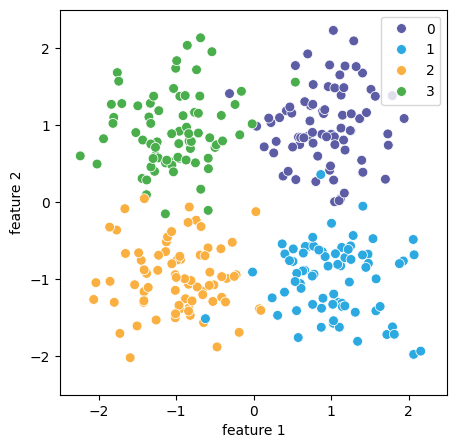

In [ ]:
dark_colors = ["#1B1464", "#0961A5", "#754C24", "#006837"]
bright_colors = ["#5D5DA6", "#2DA9E1", "#F9B041", "#4AAE4D"]
dull_cmap = ListedColormap(["#D1D5ED", "#B8E1EC", "#FEE7D0", "#C9E3C8"])

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# first fig
sns.scatterplot(
    x=x[:, 0], y=x[:, 1], hue=y, s=50, ax=ax, palette=sns.color_palette(bright_colors)
)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ["0", "1", "2", "3"])
ax.set(xlabel="feature 1", ylabel="feature 2")

plt.xlim([-2.5, 2.5])
plt.ylim([-2.5, 2.5])
plt.show()

### One vs Rest

Классификация **one vs rest** реализована в Sklearn в классе `svm.LinearSVC`:

In [ ]:
clf = svm.LinearSVC()
clf.fit(x, y)

LinearSVC()

Посмотрим, как выглядят разделяющие прямые и нормали к ним для нашей задачи:

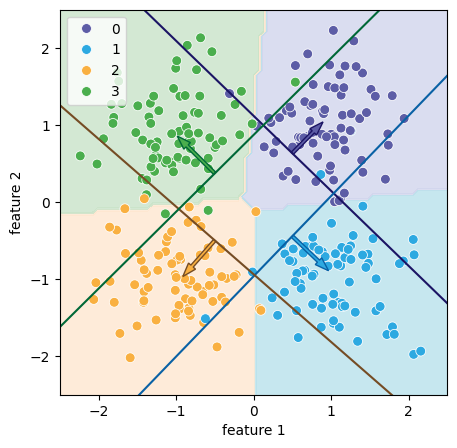

In [ ]:
from sklearn.inspection import DecisionBoundaryDisplay

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

disp = DecisionBoundaryDisplay.from_estimator(
    clf,
    x,
    response_method="predict",
    cmap=dull_cmap,
    alpha=0.8,
    xlabel="feature 1",
    ylabel="feature 2",
    ax=ax,
)

# Plot the training points
sns.scatterplot(
    x=x[:, 0], y=x[:, 1], hue=y, s=50, ax=ax, palette=sns.color_palette(bright_colors)
)

# create grid to evaluate model
xx = np.linspace(-2.5, 2.5)
# for visualization
arrow_xs = [0.5, 0.5, -0.5, -0.5]
for i in range(clf.coef_.shape[0]):
    coef = clf.coef_[i]
    w = -coef[0] / coef[1]
    b = -clf.intercept_[0] / coef[1]
    yy = w * xx + b
    # normal
    plt.arrow(
        arrow_xs[i],
        w * arrow_xs[i] + b,
        coef[0] / 4,
        coef[1] / 4,
        edgecolor=dark_colors[i],
        facecolor=bright_colors[i],
        width=0.04,
    )
    # dividing line
    plt.plot(xx, yy, dark_colors[i])

plt.xlim([-2.5, 2.5])
plt.ylim([-2.5, 2.5])

plt.show()

Коэффициенты `clf.coef_` возвращают вектор нормали. С помощью `clf.coef_` и `clf.intercept_` можно записать уравнение разделяющей прямой.

Для 4 классов стратегия **one vs rest** даст 4 разделяющие прямые (гиперплоскости). Количество разделяющих прямых равно количеству классов.

Стратегия **one vs rest** позволяет обучать меньшее количество классификаторов, чем **one vs one**, но при **большом количестве классов** могут появляться проблемы, связанные с **сильным дисбалансом классов** при решении задачи “один против всех”. При большом количестве классов лучше использовать **one vs one** стратегию.  

### One vs One

Второй стратегией многоклассовой классификации для SVM является **one vs one**, в которой классы разделяются попарно. Эта стратегия реализована в классе `svm.SVC`.

In [ ]:
clf = svm.SVC(kernel="linear")
clf.fit(x, y)

SVC(kernel='linear')

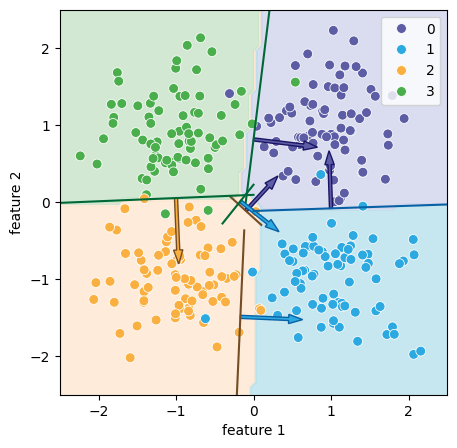

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

disp = DecisionBoundaryDisplay.from_estimator(
    clf,
    x,
    response_method="predict",
    cmap=dull_cmap,
    alpha=0.8,
    xlabel="feature 1",
    ylabel="feature 2",
    ax=ax,
)

# Plot the training points
sns.scatterplot(
    x=x[:, 0], y=x[:, 1], hue=y, s=50, ax=ax, palette=sns.color_palette(bright_colors)
)

# for visualization
arrow_xs = [1, -0.1, 0, -0.17, -0.17, -1]
colors_list = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
range_list = [(0, 2.5), (-0.3, 0.1), (-0.1, 0.5), (-1, -0.12), (-0.4, 0), (-2.5, 0)]

for i in range(clf.coef_.shape[0]):
    xx = np.linspace(*range_list[i])
    coef = clf.coef_[i]
    w = -coef[0] / coef[1]
    b = -clf.intercept_[0] / coef[1]
    yy = w * xx + b
    # normal
    plt.arrow(
        arrow_xs[i],
        w * arrow_xs[i] + b,
        coef[0] / 4,
        coef[1] / 4,
        edgecolor=dark_colors[colors_list[i][0]],
        facecolor=bright_colors[colors_list[i][0]],
        width=0.04,
    )
    # dividing line
    plt.plot(xx, yy, dark_colors[colors_list[i][1]])

plt.xlim([-2.5, 2.5])
plt.ylim([-2.5, 2.5])

plt.show()

Для 4 классов стратегия **one vs one** даст 6 разделяющих прямых (гиперплоскости). Количество разделяющих прямыx:
$$ \frac{n_\text{classes}\cdot (n_\text{classes}-1)}{2},$$
гдe $n_\text{classes}$ — количество классов.

**Практические советы по использованию SVM:**

* SVM делает **геометрическое разделение данных**, поэтому для адекватной работы модели важна **нормализация**.
* В случае **дисбаланса классов** полезно использовать параметры `class_weight` и `sample_weight` ([подробнее 🛠️[doc]](https://scikit-learn.org/stable/modules/svm.html#unbalanced-problems)).
* SVM может давать хорошее решение при небольшом количестве данных, в этом случае стоит попробовать **различные ядра** (про ядра вы узнаете ниже).

# Обобщенные линейные модели

## Полиномиальная модель

Данные не всегда могут быть **хорошо разделены (гипер)плоскостью**. Например, рассмотрим следующее: у нас есть данные по дозировке лекарства и 2 класса — пациенты, которые поправились, и те, которым лучше не стало.

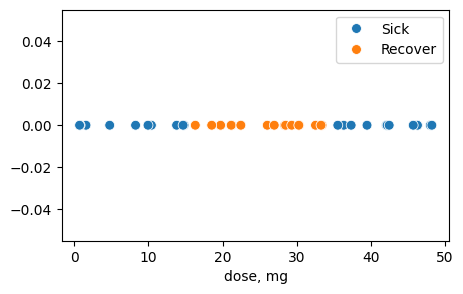

In [ ]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt


def generate_patients_data(total_len=40):
    x = np.random.uniform(0, 50, total_len)
    y = np.zeros_like(x)
    y[(x > 15) & (x < 35)] = 1
    return x, y


def plot_data(x, y, total_len=40, s=50):
    plt.figure(figsize=(5, 3))
    ax = sns.scatterplot(x=x, y=np.zeros(len(x)), hue=y, s=s)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, ["Sick", "Recover"])
    ax.set(xlabel="dose, mg")
    return ax


total_len = 40
x, y = generate_patients_data(total_len=total_len)
ax = plot_data(x, y, total_len=total_len)
plt.show()

Соответственно, мы не можем найти такое пороговое значение, которое будет разделять наши классы на больных и здоровых, а, следовательно, и Support Vector Classifier работать тоже не будет.  Для начала давайте преобразуем наши данные таким образом, чтобы они стали 2-хмерными. В качестве значений по оси Y будем использовать дозу, возведенную в квадрат (**доза**$^2$).

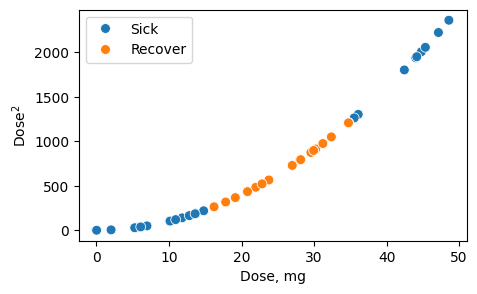

In [ ]:
def plot_data(x, y, total_len=40, s=50):
    plt.figure(figsize=(5, 3))
    ax = sns.scatterplot(x=x[0, :], y=x[1, :], hue=y, s=s)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, ["Sick", "Recover"])
    ax.set(xlabel="Dose, mg")
    ax.set(ylabel="Dose$^2$")
    return ax


total_len = 40
x_1, y = generate_patients_data(total_len=total_len)
x_2 = x_1**2
x = np.vstack([x_1, x_2])

plot_data(x, y, total_len=40, s=50)
plt.show()

Теперь мы можем вновь использовать Support Vector Classifier для классификации.

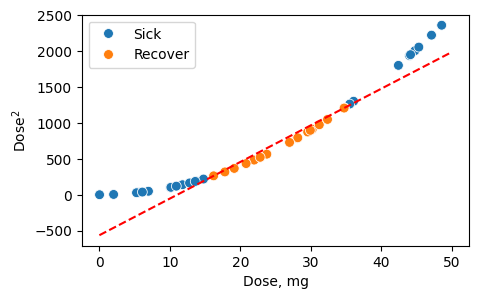

In [ ]:
plot_data(x, y, total_len=40, s=50)

x_arr = np.linspace(0, 50, 50)
xs = [x[0, :][y == 1].min(), x[0, :][y == 1].max()]
ys = [x[1, :][y == 1].min(), x[1, :][y == 1].max()]

# Calculate the coefficients.
coefficients = np.polyfit(xs, ys, 1)

# Let's compute the values of the line...
polynomial = np.poly1d(coefficients)
y_axis = polynomial(x_arr)

# ...and plot the points and the line
plt.plot(x_arr, y_axis, "r--")
plt.show()

## Kernel SVM

Основная идея **Kernel SVM** состоит в том, что **мы можем перейти в пространство большей размерности, в котором данные будут линейно разделимы**.

Но тут возникает резонный вопрос: **почему мы решили возвести в квадрат**? Почему не в куб? Или, наоборот, не извлечь корень? Как нам решить, какое преобразование использовать?

И у нас есть вторая проблема — а если перейти надо в **пространство очень большой размерности**? В этом случае наши данные очень сильно **увеличатся в размере**.

Комбинация двух проблем дает нам много сложности: надо **перебирать большое число возможных пространств большей размерности**.

 ### Обоснование Kernel SVM

Однако основная фишка **Support Vector Machine** состоит в том, что внутри он работает на скалярных произведениях. И можно эти **скалярные произведения** считать, **не переходя в пространство большей размерности**.

Для этого SVM использует **Kernel Function**.

<img src="https://ml.gan4x4.ru/msu/additions/L02/svm_kernel_function.png" width="700">


Выше мы ввели $\text{Loss}$ для **Hard Margin Classifier**:

$$\large \text{Loss} =  \frac{1}{2} ||\vec w||^2 + \sum_i \alpha_i [y_i ((\vec w, \vec x_i) + b) - 1],$$

где $\alpha_i\geq0$ — множитель Лагранжа. Он будет не равен нулю только для **опорных векторов**.

С добавлением некоторых математических ограничений эту формулу можно [переписать ✏️[blog]](https://www.geeksforgeeks.org/dual-support-vector-machine/) в **дуальной форме**:

$$\large \text{Loss} =  \sum_i \alpha_i+ \sum_i \sum_j \alpha_i \alpha_j
y_i y_j (\vec x_i, \vec x_j) = \sum_i \alpha_i+ \sum_i \sum_j \alpha_i \alpha_j
y_i y_j K(\vec x_i, \vec x_j),$$
где $(\vec x_i, \vec x_j)$ — скалярное произведение.

Для получения дуальной формы приравнивают нулю производные $\dfrac {\partial \text{Loss}} {\partial w}$ и $\displaystyle\frac {\partial \text{Loss}}{\partial b}$ и подставляют их в исходную формулу.


В этой формуле можно сделать **kernel trick** — заменить **скалярное произведение** на некоторую функцию от двух векторов, которую мы будем называть **Kernel function**.

Решающее правило в таком случае будет выглядеть как:

$$\large y=f(x)=\text{sign}(\sum_{i=1}^nα_iy_iK(x, x_i)+b),$$

где $x_i$ и $y_i$ — признаки и метки классов опорных векторов.

Важно заметить, что  **дуальная форма** записи для **многоклассовой классификации** возможна только в случае **one vs one**.

### Примеры ядер

Для демонстрации возможностей Kernel SVM создадим датасет, который не разделяется линейными моделями. Для этого воспользуемся функцией `sklearn.datasets.make_circles`.

In [ ]:
from sklearn.datasets import make_circles

x, y = make_circles(n_samples=500, factor=0.3, noise=0.05, random_state=42)

Полученный датасет представляет собой две окружности с разными радиусами и общим центром, относящиеся к разным классам.

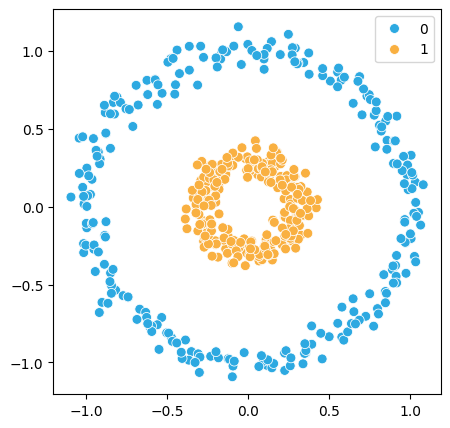

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

sns.scatterplot(
    x=x[:, 0],
    y=x[:, 1],
    hue=y,
    s=50,
    ax=ax,
    palette=sns.color_palette(["#2DA9E1", "#F9B041"]),
)
plt.show()

Напишем функцию визуализации разделяющего правила для SVM модели:

In [ ]:
from matplotlib.colors import ListedColormap
from sklearn.inspection import DecisionBoundaryDisplay


def plot_svm(x, y, clf):
    dull_cmap = ListedColormap(["#B8E1EC", "#FEE7D0"])
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        x,
        response_method="predict",
        cmap=dull_cmap,
        alpha=0.8,
        xlabel="feature 1",
        ylabel="feature 2",
        ax=ax,
    )

    sns.scatterplot(
        x=x[:, 0],
        y=x[:, 1],
        hue=y,
        s=50,
        ax=ax,
        palette=sns.color_palette(["#2DA9E1", "#F9B041"]),
    )
    plt.show()

Первое ядро, которое мы рассмотрим, линейное. Оно задается формулой:
$$\large K(\vec x_i, \vec x_j) = (\vec x_i, \vec x_j)$$

Линейным ядром является скалярное произведение векторов.

Линейное ядро не способно справиться с такой задачей:

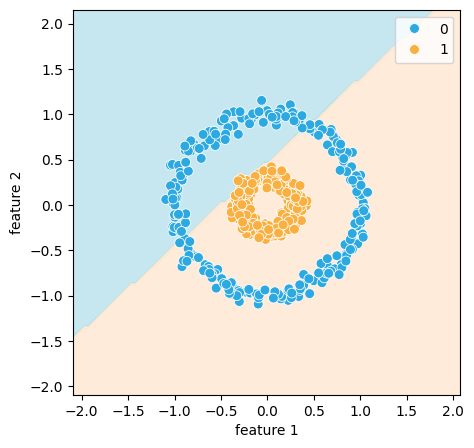

In [ ]:
from sklearn import svm

clf = svm.SVC(kernel="linear")
clf.fit(x, y)
plot_svm(x, y, clf)

Следующее ядро, реализованное в библиотеке Sklearn — полиномиальное, оно задается формулой:
$$K(\vec x_i, \vec x_j) = (\gamma (\vec x_i, \vec x_j)+r)^d,$$
где $d$ — настраиваемый параметр: степень полинома `degree`.

Попробуем применить полиномиальное ядро к нашим данным:

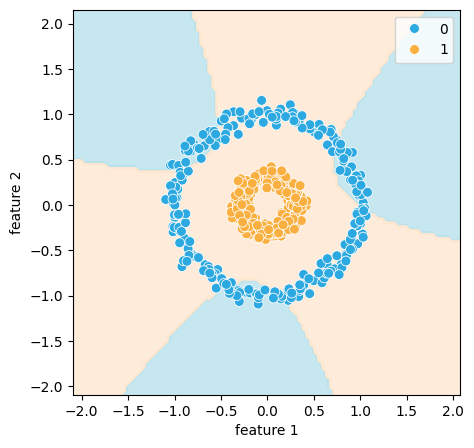

In [ ]:
clf = svm.SVC(kernel="poly")
clf.fit(x, y)
plot_svm(x, y, clf)

Полиномиальное ядро действует не совсем как полиномиальная модель.
У модели не получилось разделить данные. Это связано с тем, что значение `degree` по умолчанию равно 3, поставим степень полинома 2:

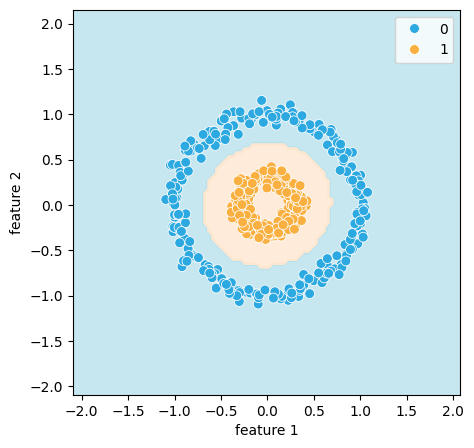

In [ ]:
clf = svm.SVC(kernel="poly", degree=2)
clf.fit(x, y)
plot_svm(x, y, clf)

Вывод, который тут стоит сделать: для получения **оптимального результата** бывает полезным **настроить параметры ядра** с учетом даных.

Самым  популярным ядром SVM является ядро радиальных базисных функций RBF, или гауссово ядро. Оно получено из гауссова  распределения, а гауссово распределение характерно для большого количества измеряемых величин. Данное ядро задается формулой:

$$\large K(\vec x_i, \vec x_j) = e^{-\gamma{||\vec x_i - \vec x_j||^2}}$$

Настраиваемыми параметрами модели являются `C` и `gamma`. `C` определяет степень гладкости поверхности принятия решений: чем больше `C`, тем сложнее поверхность и **выше вероятность переобучения** (про переобучение поговорим ниже), `gamma` определяет степень влияния одного обучающего примера на разделяющее правило ([подробнее 🛠️[doc]](https://scikit-learn.org/stable/modules/svm.html#parameters-of-the-rbf-kernel)).

SVM может проверять пространства признаков бесконечного размера, если для такого пространства существует kernel function. RBF ядро как раз [соответствует 📚[book]](https://pages.cs.wisc.edu/~matthewb/pages/notes/pdf/svms/RBFKernel.pdf) такому случаю бесконечномерного пространства признаков.

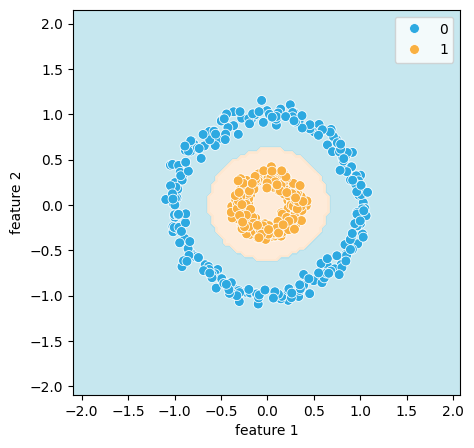

In [ ]:
clf = svm.SVC(kernel="rbf")
clf.fit(x, y)
plot_svm(x, y, clf)

Также в Sklearn реализовано `sigma` ядро. Оно интересно больше с исторической точки зрения, т.к. эквивалентно модели нейрона — Перцептрону, о котором вы узнаете на 5-й лекции. [На практике 🎓[article]](https://home.work.caltech.edu/~htlin/publication/doc/tanh.pdf) оно в большинстве случаев проигрывает RBF ядру.

$$\large K(\vec x_i, \vec x_j) = \tanh (\gamma(\vec x_i, \vec x_j)+r)$$